## Setup Environment

In [1]:
!pip install -U scikit-learn
!pip install -U lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 78.4 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [76]:
import os
import time
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sklearn
import xgboost as xgb
from sklearn.svm import SVR, SVC
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler

In [3]:
import tensorflow as tf
import keras
import numpy as np
from keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Activation, Input, Dropout, LSTM
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

## Data Processing and Analysis

In [4]:
!git clone https://github.com/Scriea/CL688.git
%cd ./CL688/

Cloning into 'CL688'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 48 (delta 2), reused 18 (delta 0), pack-reused 24
Receiving objects: 100% (48/48), 72.29 MiB | 15.19 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (22/22), done.
/content/CL688


In [31]:
path_small_office = "data/1_small_office_summary_1.csv"
path_medium_office = "data/5_medium_office_summary_1.csv"
path_large_office = "data/8_large_office_summary_1.csv"

In [35]:
temp = pd.read_csv(path_small_office)
temp.head(10)

,Unnamed: 0,Time,Date/Time,Climate Zone/City,Dry Bulb (C),Dew Point (C),Relative Humidity (%),Atmos Pressure (Pa),Extraterrestrial Horizontal Radiation (Wh/m2),Extraterrestrial Direct Normal Radiation (Wh/m2),...,PERIMETER_ZN_3:Zone Air System Sensible Cooling Energy (J),PERIMETER_ZN_3:Zone Air System Sensible Heating Rate (W),PERIMETER_ZN_3:Zone Air System Sensible Cooling Rate (W),PERIMETER_ZN_4:Zone Air System Sensible Heating Energy (J),PERIMETER_ZN_4:Zone Air System Sensible Cooling Energy (J),PERIMETER_ZN_4:Zone Air System Sensible Heating Rate (W),PERIMETER_ZN_4:Zone Air System Sensible Cooling Rate (W),Whole Building:Facility Total Building Electric Demand Power (W),Whole Building:Facility Total HVAC Electric Demand Power (W),Whole Building:Facility Total Electric Demand Power (W)
0,0,1,1:00:00,"1A,Honolulu",21.1,16.7,76,101800,0,0,...,0.000000e+00,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,1627.073021,571.000000,2198.073021
1,1,2,2:00:00,"1A,Honolulu",20.6,16.7,79,101700,0,0,...,0.000000e+00,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,1627.073021,571.000000,2198.073021
2,2,3,3:00:00,"1A,Honolulu",20.0,16.7,81,101600,0,0,...,0.000000e+00,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,1627.073021,571.000000,2198.073021
3,3,4,4:00:00,"1A,Honolulu",18.9,16.7,87,101600,0,0,...,0.000000e+00,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,1627.073021,571.000000,2198.073021
4,4,5,5:00:00,"1A,Honolulu",17.8,16.1,90,101700,0,0,...,0.000000e+00,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,1627.073021,571.000000,2198.073021
5,5,6,6:00:00,"1A,Honolulu",17.8,17.2,97,101700,0,0,...,0.000000e+00,0.000000,0.000000,0.00000,0.000000e+00,0.000000,0.000000,1627.073021,571.000000,2198.073021
6,6,7,7:00:00,"1A,Honolulu",18.3,16.7,90,101700,0,0,...,0.000000e+00,223.031822,0.000000,824109.01090,0.000000e+00,228.919170,0.000000,2627.109578,1795.218374,4422.327952
7,7,8,8:00:00,"1A,Honolulu",19.4,17.8,90,101800,93,1144,...,3.862292e+04,2.311055,10.728589,349975.97910,0.000000e+00,97.215550,0.000000,2677.811352,1855.412375,4533.223727
8,8,9,9:00:00,"1A,Honolulu",23.9,18.9,74,101900,377,1415,...,4.192861e+05,20.268257,116.468354,63810.34242,3.813551e+05,17.725095,105.931979,5186.823787,3134.668008,8321.491795
9,9,10,10:00:00,"1A,Honolulu",26.1,18.3,62,101900,634,1415,...,2.037237e+06,0.000000,565.899114,0.00000,1.333961e+06,0.000000,370.544777,5100.216186,4099.720743,9199.936929


In [34]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76800 entries, 0 to 76799
Data columns (total 52 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   Unnamed: 0                                                        76800 non-null  int64  
 1   Time                                                              76800 non-null  int64  
 2   Date/Time                                                         76800 non-null  object 
 3   Climate Zone/City                                                 76800 non-null  object 
 4   Dry Bulb (C)                                                      76800 non-null  float64
 5   Dew Point (C)                                                     76800 non-null  float64
 6   Relative Humidity (%)                                             76800 non-null  int64  
 7   Atmos Pressure (Pa)            

In [7]:
def get_data(path):
  df = pd.read_csv(path)
  X = df.iloc[:, 4:21]
  Y = df.iloc[:, -3:-1]
  X = X.to_numpy()
  Y = Y.to_numpy()
  scaler_X = StandardScaler()
  X_scaled = scaler_X.fit_transform(X)
  return X_scaled,Y

def get_all_data():
  df_small_office = pd.read_csv(path_small_office)
  df_medium_office = pd.read_csv(path_medium_office)
  df_large_office= pd.read_csv(path_large_office)
  df_merged = pd.merge(df_small_office, df_medium_office, how="outer")
  df_merged = pd.merge(df_merged, df_large_office, how = "outer")
  X = df_merged.iloc[:, 4:21]
  Y = df_merged.iloc[:, -3:-1]
  X = X.to_numpy()
  Y = Y.to_numpy()
  scaler_X = StandardScaler()
  X_scaled = scaler_X.fit_transform(X)
  return X_scaled,Y

In [8]:
X, Y = get_all_data()
X = X.astype('float32')
Y = Y.astype('float32')

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.05, random_state=42)

In [10]:
Y_train_electric = Y_train[:, 0]
Y_train_thermal = Y_train[:, 1]
Y_test_electric = Y_test[:, 0]
Y_test_thermal = Y_test[:, 1]

### Helper Functions



In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))
def r_squared(y_true, y_pred):
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res/(SS_tot + tf.keras.backend.epsilon())


def regression_report(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R2): {r2}")

_______________________________________________________________________________

# Algorithms - Regression Problem

## Linear Regression

In [12]:
linear_model = LinearRegression()
linear_model = MultiOutputRegressor(linear_model)

In [13]:
linear_model.fit(X_train, Y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [14]:
Y_train_pred = linear_model.predict(X_train)
Y_test_pred = linear_model.predict(X_test)

print("---------\t Train Regression Report \t---------")
regression_report(Y_train, Y_train_pred)

print("\n\n")
print("---------\t Test Regression Report \t---------")
regression_report(Y_test, Y_test_pred)

---------	 Train Regression Report 	---------
Mean Squared Error (MSE): 7590337024.0
Mean Absolute Error (MAE): 62033.953125
Root Mean Squared Error (RMSE): 87122.5390625
R-squared (R2): 0.8436384379645572



---------	 Test Regression Report 	---------
Mean Squared Error (MSE): 7556290048.0
Mean Absolute Error (MAE): 61903.671875
Root Mean Squared Error (RMSE): 86926.921875
R-squared (R2): 0.843366058435913


In [15]:
with open('linear_regression.pkl', 'wb') as f:
    pickle.dump(linear_model, f)

## Support Vector Regression

SVM Regressor wasn't used on full dataset because of its computational expense. SVM Regressor have cubic time complexity and it was taking a lot of time to train on full data.

In [ ]:
X_small_office,Y_small_office = get_data(path_small_office)
X_small_office = X_small_office.astype('float32')
Y_small_office = Y_small_office.astype('float32')

In [ ]:
X_small_office_train, X_small_office_test, Y_small_office_train, Y_small_office_test = train_test_split( X_small_office, Y_small_office, test_size=0.05, random_state=42)

In [ ]:
svr_rbf = SVR(kernel="rbf")
svr_rbf = MultiOutputRegressor(svr_rbf)
svr_rbf.fit(X_small_office_train, Y_small_office_train)

MultiOutputRegressor(estimator=SVR())

In [ ]:
Y_train_pred = svr_rbf.predict(X_small_office_train)
Y_test_pred = svr_rbf.predict(X_small_office_test)

print("---------\t Train Regression Report \t---------")
regression_report(Y_train, Y_train_pred)
print("\n\n")
print("---------\t Test Regression Report \t---------")
regression_report(Y_test, Y_test_pred)

---------	 Train Regression Report 	---------
Mean Squared Error (MSE): 1794410.6148981343
Mean Absolute Error (MAE): 852.1322548488179
Root Mean Squared Error (RMSE): 1339.5561260724144
R-squared (R2): 0.5208687957761851



---------	 Test Regression Report 	---------
Mean Squared Error (MSE): 1894250.0158693737
Mean Absolute Error (MAE): 878.6181154100718
Root Mean Squared Error (RMSE): 1376.3175563326124
R-squared (R2): 0.5105751583540248


#### Save Model

In [ ]:
with open('svr_rbf.pkl', 'wb') as f:
    pickle.dump(svr_rbf, f)

_______________________________

## Vanilla Deep Neural Network

In [ ]:
model = Sequential([
    Input(shape= X_train.shape[1:]),
    Dense(256, activation= 'relu', kernel_initializer='he_uniform'),
    Dropout(0.1),
    Dense(128, activation= 'relu', kernel_initializer='he_uniform'),
    Dropout(0.1),
    Dense(128, activation= 'relu', kernel_initializer='he_uniform'),
    Dropout(0.1),
    Dense(64, activation= 'relu', kernel_initializer='he_uniform'),
    Dense(2, activation= 'relu', kernel_initializer='he_uniform')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               4608      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [ ]:
# model.compile(loss='mean_squared_error', optimizer=SGD(learning_rate=0.001, momentum=0.9), metrics=['accuracy'])
mse = tf.keras.losses.MeanSquaredError()
mae = tf.keras.losses.MeanAbsoluteError()
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[mse, mae, root_mean_squared_error, r_squared])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [ ]:
history = model.fit(X_train, Y_train, epochs=50, validation_data=(X_test, Y_test), verbose=1, callbacks=[callback])

Epoch 1/50
5760/5760 [==============================] - 379s 66ms/step - loss: 8188959232.0000 - mean_squared_error: 8188959232.0000 - mean_absolute_error: 41915.1914 - root_mean_squared_error: 74872.0078 - r_squared: 0.9231 - val_loss: 2608637184.0000 - val_mean_squared_error: 2608637184.0000 - val_mean_absolute_error: 26104.4551 - val_root_mean_squared_error: 49563.0664 - val_r_squared: 0.9759
Epoch 2/50
5760/5760 [==============================] - 372s 65ms/step - loss: 3000694784.0000 - mean_squared_error: 3000694784.0000 - mean_absolute_error: 28015.1230 - root_mean_squared_error: 53200.8672 - r_squared: 0.9719 - val_loss: 2328542976.0000 - val_mean_squared_error: 2328542976.0000 - val_mean_absolute_error: 24170.5508 - val_root_mean_squared_error: 46654.0273 - val_r_squared: 0.9785
Epoch 3/50
5760/5760 [==============================] - 372s 65ms/step - loss: 2772050176.0000 - mean_squared_error: 2772050176.0000 - mean_absolute_error: 26426.3223 - root_mean_squared_error: 51037.01

In [ ]:
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)

5760/5760 [==============================] - 39s 7ms/step


In [ ]:
print("---------\t Train Regression Report \t---------")
regression_report(Y_train, Y_train_pred)

print("\n\n")
print("---------\t Test Regression Report \t---------")
regression_report(Y_test, Y_test_pred)

---------	 Train Regression Report 	---------
Mean Squared Error (MSE): 1098853120.0
Mean Absolute Error (MAE): 16174.0234375
Root Mean Squared Error (RMSE): 33148.953125
R-squared (R2): 0.9851460396843741



---------	 Test Regression Report 	---------
Mean Squared Error (MSE): 1148508928.0
Mean Absolute Error (MAE): 16550.6875
Root Mean Squared Error (RMSE): 33889.65625
R-squared (R2): 0.984827428239968


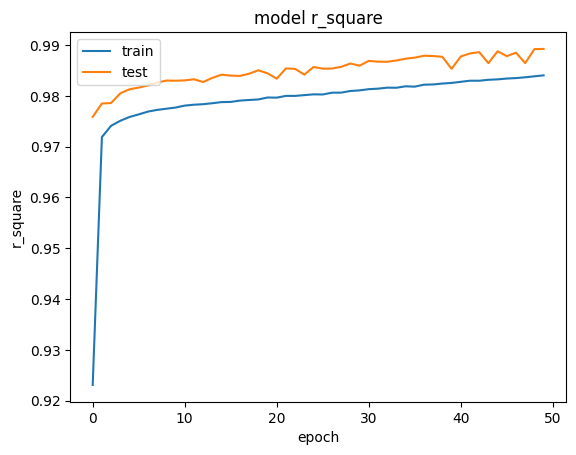

In [ ]:
plt.plot(history.history['r_squared'])
plt.plot(history.history['val_r_squared'])
plt.title('model r_square')
plt.ylabel('r_square')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

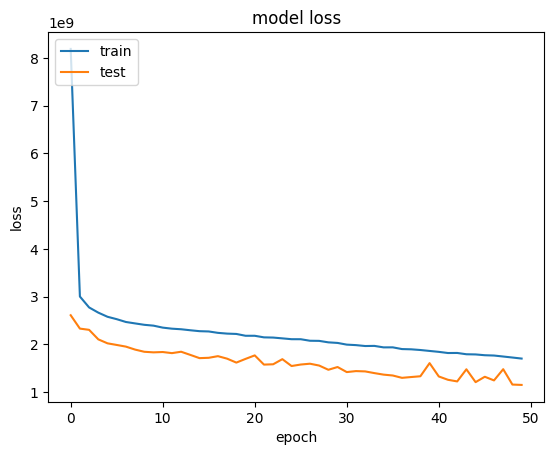

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Save Model

In [ ]:
model.save('nn_regression.h5')
print('Model Saved!')

#### Load Saved model

In [ ]:
savedModel=load_model('nn_regression.h5')

## Boosting

#### XGBoost

In [16]:
model = xgb.XGBRegressor(objective="reg:linear", random_state=42)
model.fit(X_train, Y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:55:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [17]:
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)

In [20]:
print("---------\t Train Regression Report \t---------")
regression_report(Y_train, Y_train_pred)

print("---------\t Test Regression Report \t---------")
regression_report(Y_test, Y_test_pred)

---------	 Train Regression Report 	---------
Mean Squared Error (MSE): 200348864.0
Mean Absolute Error (MAE): 7451.7724609375
Root Mean Squared Error (RMSE): 14154.46484375
R-squared (R2): 0.9971314337445218
---------	 Test Regression Report 	---------
Mean Squared Error (MSE): 219277200.0
Mean Absolute Error (MAE): 7763.5908203125
Root Mean Squared Error (RMSE): 14808.01171875
R-squared (R2): 0.99682176483135


In [36]:
model.save_model('XGB_Regression_Electrical.json')

### LightGBM

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

In [ ]:
params = {
 "boosting_type": "gbdt",
 "objective": "regression",
 "device_type":"cpu",
 "metric": {"l2", "l1"},
 "num_leaves": 31,
 "learning_rate": 0.05,
 "feature_fraction": 0.9,
 "bagging_fraction": 0.8,
 "bagging_freq": 5,
 "verbose": 0
}

In [ ]:
train_data = lgb.Dataset(X_train, label=Y_train_electric)
valid_data = lgb.Dataset(X_test, label=Y_test_electric)

In [ ]:
model = LGBMRegressor(**params)
num_round = 200  # Number of boosting iterations
model = lgb.train(params, train_data, num_round, valid_sets=[valid_data])

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:599: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "


In [ ]:
Y_test_pred_electric = model.predict(X_test)
Y_train_pred_electric = model.predict(X_train)

In [ ]:
print("---------\t Train Regression Report \t---------")
regression_report(Y_train_electric, Y_train_pred_electric)

print("---------\t Test Regression Report \t---------")
regression_report(Y_test_electric, Y_test_pred_electric)

---------	 Train Regression Report 	---------
Mean Squared Error (MSE): 846879981.3836108
Mean Absolute Error (MAE): 15330.708073171261
Root Mean Squared Error (RMSE): 29101.202404430143
R-squared (R2): 0.9951762559744048
---------	 Test Regression Report 	---------
Mean Squared Error (MSE): 907322525.5461911
Mean Absolute Error (MAE): 15885.209497662856
Root Mean Squared Error (RMSE): 30121.79485930729
R-squared (R2): 0.9948742527120209


Save Model

In [ ]:
model.save_model('LGB_Regression_Electrical.txt')

Load Saved Model

In [ ]:
savmodel = lgb.Booster(model_file='LGB_Regression_Electrical.txt')

-------------------------------------------------------------------

In [ ]:
train_data = lgb.Dataset(X_train, label=Y_train_thermal)
valid_data = lgb.Dataset(X_test, label=Y_test_thermal)

In [ ]:
model = LGBMRegressor(**params)
num_round = 200  # Number of boosting iterations
model = lgb.train(params, train_data, num_round, valid_sets=[valid_data])

# Algorithms - Classification Problem



## Labelling Classes


In [22]:
df_small_office = pd.read_csv(path_small_office)
df_small_office['Cluster'] = 0
main_group_size = 8
for index, row in df_small_office.iterrows():
    main_cluster_label = (index // main_group_size) + 1
    df_small_office.at[index, 'Cluster'] = main_cluster_label
print(df_small_office['Cluster'])

0           1
1           1
2           1
3           1
4           1
         ... 
76795    9600
76796    9600
76797    9600
76798    9600
76799    9600
Name: Cluster, Length: 76800, dtype: int64


In [69]:
df_small_office.groupby('Cluster')['trend'].count()

Cluster
1       7
2       8
3       8
4       8
5       8
       ..
9596    0
9597    0
9598    0
9599    0
9600    0
Name: trend, Length: 9600, dtype: int64

In [37]:
import pandas as pd
from scipy.signal import find_peaks

def analyze_trend(Cluster):
    peaks, _ = find_peaks(Cluster['Whole Building:Facility Total HVAC Electric Demand Power (W)'])

    if len(peaks) > 0:
        return 'cyclic'
    elif Cluster['Whole Building:Facility Total HVAC Electric Demand Power (W)'].nunique() == 1:
        return 'constant'
    elif all(Cluster['Whole Building:Facility Total HVAC Electric Demand Power (W)'].diff().dropna() > 0):
        return 'increasing'
    elif all(Cluster['Whole Building:Facility Total HVAC Electric Demand Power (W)'].diff().dropna() < 0):
        return 'decreasing'
    else:
        return 'unknown'

df_small_office['trend'] = df_small_office.groupby('Cluster').apply(analyze_trend)

In [38]:
increasing_rows = df_small_office[df_small_office['trend'] == 'increasing']
print(increasing_rows[['Whole Building:Facility Total HVAC Electric Demand Power (W)', 'trend']])

decreasing_rows = df_small_office[df_small_office['trend'] == 'decreasing']
print(decreasing_rows[['Whole Building:Facility Total HVAC Electric Demand Power (W)', 'trend']])

constant_rows = df_small_office[df_small_office['trend'] == 'constant']
print(constant_rows[['Whole Building:Facility Total HVAC Electric Demand Power (W)', 'trend']])

      Whole Building:Facility Total HVAC Electric Demand Power (W)       trend
26                                           571.000000             increasing
29                                          1799.521573             increasing
56                                          5571.647609             increasing
212                                          571.000000             increasing
218                                          571.000000             increasing
...                                                 ...                    ...
9434                                         571.000000             increasing
9437                                        2517.220841             increasing
9449                                        2328.668983             increasing
9452                                         571.000000             increasing
9500                                         696.000000             increasing

[218 rows x 2 columns]
      Whole Building:Facilit

In [70]:
increasing_rows

,Unnamed: 0,Time,Date/Time,Climate Zone/City,Dry Bulb (C),Dew Point (C),Relative Humidity (%),Atmos Pressure (Pa),Extraterrestrial Horizontal Radiation (Wh/m2),Extraterrestrial Direct Normal Radiation (Wh/m2),...,PERIMETER_ZN_3:Zone Air System Sensible Cooling Rate (W),PERIMETER_ZN_4:Zone Air System Sensible Heating Energy (J),PERIMETER_ZN_4:Zone Air System Sensible Cooling Energy (J),PERIMETER_ZN_4:Zone Air System Sensible Heating Rate (W),PERIMETER_ZN_4:Zone Air System Sensible Cooling Rate (W),Whole Building:Facility Total Building Electric Demand Power (W),Whole Building:Facility Total HVAC Electric Demand Power (W),Whole Building:Facility Total Electric Demand Power (W),Cluster,trend
26,26,3,3:00:00,"1A,Honolulu",21.7,16.1,71,101900,0,0,...,0.000000,0.000000e+00,0.000,0.000000,0.000000,1627.073021,571.000000,2198.073021,4,increasing
29,29,6,6:00:00,"1A,Honolulu",21.7,16.7,73,101800,0,0,...,0.000000,8.181115e+05,0.000,227.253205,0.000000,2627.109578,1799.521573,4426.631151,4,increasing
56,56,9,9:00:00,"1A,Honolulu",27.2,21.7,72,101600,699,1326,...,1871.390257,0.000000e+00,3988833.562,0.000000,1108.009323,5025.669648,5571.647609,10597.317260,8,increasing
212,212,21,21:00:00,"2B,Tucson",13.0,-1.0,38,91900,0,0,...,0.000000,0.000000e+00,0.000,0.000000,0.000000,1883.356749,571.000000,2454.356749,27,increasing
218,218,3,3:00:00,"2B,Tucson",18.0,-3.0,23,92100,0,0,...,0.000000,0.000000e+00,0.000,0.000000,0.000000,1627.073021,571.000000,2198.073021,28,increasing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9434,9434,3,3:00:00,"2B,Tucson",18.0,-3.0,23,92100,0,0,...,0.000000,0.000000e+00,0.000,0.000000,0.000000,1824.725151,571.000000,2395.725151,1180,increasing
9437,9437,6,6:00:00,"2B,Tucson",16.0,-2.0,28,92200,0,0,...,0.000000,8.451242e+05,0.000,234.756726,0.000000,2941.961755,2517.220841,5459.182595,1180,increasing
9449,9449,18,18:00:00,"2B,Tucson",30.0,-12.0,5,92200,359,1366,...,0.000000,1.764333e+06,0.000,490.092539,0.000000,1860.581059,2328.668983,4189.250042,1182,increasing
9452,9452,21,21:00:00,"2B,Tucson",25.0,-3.0,15,92100,0,0,...,0.000000,0.000000e+00,0.000,0.000000,0.000000,2109.150565,571.000000,2680.150565,1182,increasing


In [39]:
df_small_office[['Whole Building:Facility Total Electric Demand Power (W)','trend']].head(10)

,Whole Building:Facility Total Electric Demand Power (W),trend
0,2198.073021,NaN
1,2198.073021,unknown
2,2198.073021,cyclic
3,2198.073021,unknown
4,2198.073021,unknown
5,2198.073021,cyclic
6,4422.327952,unknown
7,4533.223727,cyclic
8,8321.491795,cyclic
9,9199.936929,unknown


In [45]:
df_small_office.describe()

,Unnamed: 0,Time,Dry Bulb (C),Dew Point (C),Relative Humidity (%),Atmos Pressure (Pa),Extraterrestrial Horizontal Radiation (Wh/m2),Extraterrestrial Direct Normal Radiation (Wh/m2),Horizontal Infrared Radiation Intensity from Sky (Wh/m2),Global Horizontal Radiation (Wh/m2),...,PERIMETER_ZN_3:Zone Air System Sensible Heating Rate (W),PERIMETER_ZN_3:Zone Air System Sensible Cooling Rate (W),PERIMETER_ZN_4:Zone Air System Sensible Heating Energy (J),PERIMETER_ZN_4:Zone Air System Sensible Cooling Energy (J),PERIMETER_ZN_4:Zone Air System Sensible Heating Rate (W),PERIMETER_ZN_4:Zone Air System Sensible Cooling Rate (W),Whole Building:Facility Total Building Electric Demand Power (W),Whole Building:Facility Total HVAC Electric Demand Power (W),Whole Building:Facility Total Electric Demand Power (W),Cluster
count,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,...,76800.000000,76800.000000,7.680000e+04,7.680000e+04,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000,76800.000000
mean,38399.500000,12.500000,8.590039,0.357422,62.283854,95670.377604,288.604818,650.572917,304.188802,168.020182,...,207.636738,339.672699,4.610051e+05,9.534223e+05,128.056965,264.839534,3610.703735,2296.587550,5907.291285,4800.500000
std,22170.394674,6.922232,14.141276,13.118430,24.766941,6316.588000,390.800357,666.644382,69.924034,257.172725,...,666.474695,646.806387,1.512012e+06,1.927147e+06,420.003446,535.318520,2004.243736,1896.667415,3543.939259,2771.299319
min,0.000000,1.000000,-32.800000,-36.100000,4.000000,81300.000000,0.000000,0.000000,128.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,992.627576,571.000000,1563.627576,1.000000
25%,19199.750000,6.750000,0.000000,-7.850000,43.000000,91175.000000,0.000000,0.000000,257.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,1883.356749,571.000000,2563.365374,2400.750000
50%,38399.500000,12.500000,9.400000,0.600000,65.000000,98300.000000,3.000000,213.000000,305.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,2640.470007,2018.039978,5114.730433,4800.500000
75%,57599.250000,18.250000,19.000000,11.000000,82.000000,100025.000000,558.000000,1366.000000,357.000000,269.250000,...,0.000000,389.790329,0.000000e+00,8.708537e+05,0.000000,241.903799,5598.978614,3309.986984,9008.759521,7200.250000
max,76799.000000,24.000000,37.000000,23.800000,100.000000,102800.000000,1320.000000,1415.000000,459.000000,964.000000,...,7854.903220,3848.180576,1.743141e+07,1.504432e+07,4842.057436,4178.978669,8851.599907,11133.938890,16929.665140,9600.000000


In [66]:
df_small_office['trend'].isna().sum()

67200

In [100]:
def get_data(df):
  df = df.dropna()
  X = df.iloc[:, 4:21]
  Y = df.iloc[:, -1]
  X = X.to_numpy()
  Y = Y.to_numpy()
  scaler_X = StandardScaler()
  X_scaled = scaler_X.fit_transform(X)
  return X_scaled,Y

In [101]:
X, Y = get_data(df_small_office)

In [102]:
X

array([[ 0.82244671,  1.2191295 ,  0.68508093, ...,  0.14547617,
        -1.5379423 ,  1.03590525],
       [ 0.77999557,  1.2191295 ,  0.76574788, ...,  0.14547617,
        -1.5379423 ,  1.03590525],
       [ 0.70216847,  1.2191295 ,  1.00774875, ...,  0.14547617,
        -1.5379423 ,  1.03590525],
       ...,
       [ 0.03002534, -0.29925845, -0.84759123, ...,  1.62819086,
         0.27287029, -1.69905395],
       [ 0.07247649, -0.26129875, -0.84759123, ...,  1.62819086,
         0.27287029, -1.69905395],
       [-0.67749374, -1.02049272, -1.0895921 , ...,  1.62819086,
         0.27287029, -1.69905395]])

In [103]:
classes = ['cyclic', 'constant', 'increasing', 'decreasing', 'unknown']
label = {
  'cyclic': 0,
  'constant': 1,
  'increasing': 2,
  'decreasing':3,
  'unknown':4,
         }

In [106]:
y = []
for i in Y:
  y.append(label[i])
y = np.array(y)

In [107]:
 X_train, X_test, Y_train, Y_test = train_test_split( X, y, test_size=0.3, random_state=42)

In [108]:
model = SVC(kernel = 'rbf')

In [109]:
model.fit(X_train, Y_train)

SVC()

In [110]:
Y_train_pred = model.predict(X_train)
Y_test_pred = model.predict(X_test)

In [111]:
from sklearn.metrics import accuracy_score

print('Test Accuracy     : {:.3f}'.format(accuracy_score(Y_test_pred, Y_test)))
print('Test Accuracy     : {:.3f}'.format(model.score(X_test, Y_test))) ## Score method also evaluates accuracy for classification models.
print('Training Accuracy : {:.3f}'.format(model.score(X_train, Y_train)))

Test Accuracy     : 0.548
Test Accuracy     : 0.548
Training Accuracy : 0.577
